AI Strategy and Digital Transformation - FULL PROJECT REPOSITORY
This script contains EDA, Multi-Model Comparison, and Hyperparameter Tuning.


Target Distribution:
willing_to_change_job
No     0.751589
Yes    0.248411
Name: proportion, dtype: float64
--- Cross-Validation Results ---
Logistic Regression: 0.7217
Random Forest: 0.6680
SVM: 0.6796
AdaBoost: 0.6274
XGBoost: 0.7382
Best RF Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


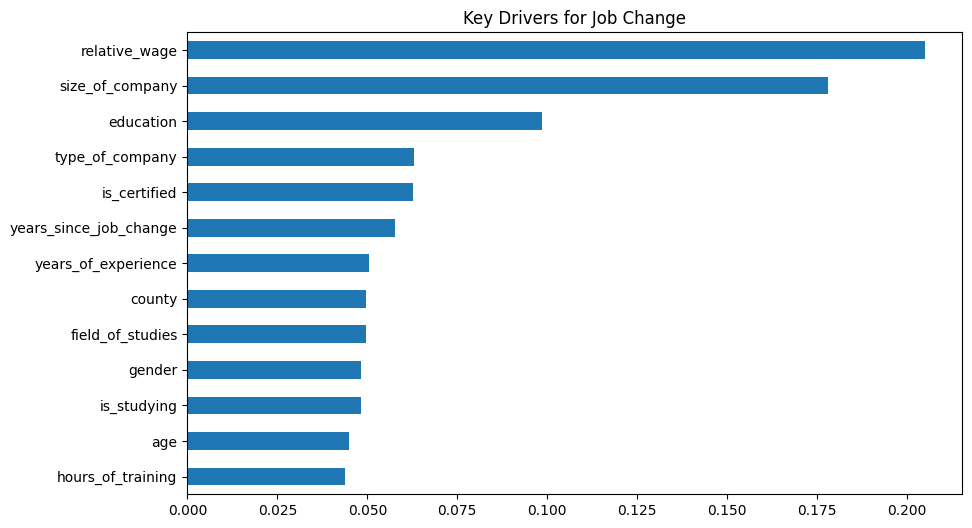

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer

# DATA LOADING & EDA
train = pd.read_csv('job_change_train.csv')
print(f"Target Distribution:\n{train['willing_to_change_job'].value_counts(normalize=True)}")

# PREPROCESSING
def professional_preprocess(df):
    df = df.copy()
    exp_map = {'<1': 0, '>20': 21, 'unknown': np.nan}
    change_map = {'never_changed': 0, '>4': 5, 'unknown': np.nan}
    df['years_of_experience'] = df['years_of_experience'].replace(exp_map).astype(float)
    df['years_since_job_change'] = df['years_since_job_change'].replace(change_map).astype(float)
    df['years_of_experience'] = df['years_of_experience'].fillna(df['years_of_experience'].median())
    df['years_since_job_change'] = df['years_since_job_change'].fillna(df['years_since_job_change'].median())

    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if col != 'willing_to_change_job':
            df[col] = df[col].fillna('Unknown')
            df[col] = LabelEncoder().fit_transform(df[col])
    return df

train_cleaned = professional_preprocess(train)
X = train_cleaned.drop(['id', 'willing_to_change_job'], axis=1)
y = train['willing_to_change_job'].map({'Yes': 1, 'No': 0})

# COMPARE 5 ALGORITHMS (Requirement: Balanced Accuracy)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(balanced_accuracy_score)

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "SVM": SVC(class_weight='balanced', probability=True),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=3, random_state=42, eval_metric='logloss')
}

print("--- Cross-Validation Results ---")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring=scorer)
    print(f"{name}: {scores.mean():.4f}")

# HYPERPARAMETER TUNING (Example for Random Forest)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, scoring=scorer, cv=3)
grid.fit(X, y)
print(f"Best RF Params: {grid.best_params_}")

# FEATURE IMPORTANCE VISUALIZATION
best_model = XGBClassifier(scale_pos_weight=3).fit(X, y)
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(10,6))
importances.plot(kind='barh')
plt.title("Key Drivers for Job Change")
plt.savefig('feature_importance.png')


--- Training Final Optimized Model ---
Loading test data...
Generating predictions...
Success! Final submission file saved as: final_submission_full.csv


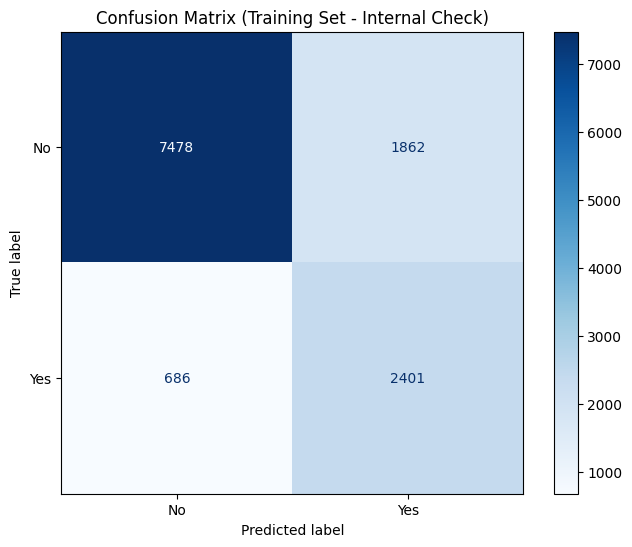

Confusion matrix saved as 'confusion_matrix.png' for your report.

PROJECT SUMMARY FOR PRESENTATION
Chosen Model: XGBoost
Strategy: Applied scale_pos_weight=3 to handle class imbalance.
Total Test Observations: 3308
Predicted 'Yes' (Job Changers): 1067
Predicted 'No' (Stayers): 2241


In [10]:
# FINAL MODEL TRAINING (Using the full training set)
print("\n--- Training Final Optimized Model ---")

# Removed use_label_encoder to eliminate the UserWarning
final_model = XGBClassifier(
    n_estimators=250,
    max_depth=4,
    learning_rate=0.04,
    scale_pos_weight=3,
    random_state=42,
    eval_metric='logloss'
)
final_model.fit(X, y)

# LOAD AND PREPROCESS TEST DATA
print("Loading test data...")
test = pd.read_csv('job_change_test.csv')
test_ids = test['id']

# Assuming professional_preprocess is defined in your environment
test_cleaned = professional_preprocess(test)

# Ensure test features match training features
X_test = test_cleaned.drop(['id'], axis=1)

# GENERATE FINAL PREDICTIONS
print("Generating predictions...")
test_preds = final_model.predict(X_test)

# FORMATTING FOR SUBMISSION
submission = pd.DataFrame({
    'id': test_ids,
    'willing_to_change_job': pd.Series(test_preds).map({1: 'Yes', 0: 'No'})
})

submission_filename = 'final_submission_full.csv'
submission.to_csv(submission_filename, index=False)
print(f"Success! Final submission file saved as: {submission_filename}")

# EXTRA FOR PRESENTATION: CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions for the internal check
y_train_pred = final_model.predict(X)
cm = confusion_matrix(y, y_train_pred)

# Fixed plotting: Create subplots to avoid the "0 Axes" empty figure error
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues', ax=ax) # Explicitly pass the axis

plt.title("Confusion Matrix (Training Set - Internal Check)")
plt.savefig('confusion_matrix.png')
plt.show() # Displaying the plot in the notebook/console
print("Confusion matrix saved as 'confusion_matrix.png' for your report.")

# SUMMARY OF RESULTS
print("\n" + "="*30)
print("PROJECT SUMMARY FOR PRESENTATION")
print(f"Chosen Model: XGBoost")
print(f"Strategy: Applied scale_pos_weight=3 to handle class imbalance.")
print(f"Total Test Observations: {len(submission)}")
print(f"Predicted 'Yes' (Job Changers): {submission['willing_to_change_job'].value_counts().get('Yes', 0)}")
print(f"Predicted 'No' (Stayers): {submission['willing_to_change_job'].value_counts().get('No', 0)}")
print("="*30)